In [14]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from copy import deepcopy

In [15]:
volume = pd.read_csv('./data/volume_RB2201.csv')
time = pd.read_csv('./data/time_RB2201.csv')
volume = volume[volume["close"]!=0]
time = time[time["close"]!=0]
volume.rename(columns={'Unnamed: 0':'t'},inplace=True)
time.rename(columns={'Unnamed: 0':'t'},inplace=True)
volume = volume.reset_index(drop=True)
time = time.reset_index(drop=True)

我们选取主力合约期间的三个月（'2021-11-01 -- 2022-02-01）

In [16]:
volume = volume[(volume['t'] > '2021-11-01') & (volume['t'] < '2022-02-01')]
time = time[(time['t'] > '2021-11-01') & (time['t'] < '2022-02-01')]

下面的训练区间选择2021-11-01 -- 2022-01-01

测试区间为 2022-01-01 -- 2022-02-01

In [17]:
def backtest(df: pd.DataFrame):
    total_pnl = pd.DataFrame(columns=['t','total_pnl'])
    cost = 0.0002
    cash = 0
    position = 0
    for i in range(len(df.index)-1):
        signal = df['Signal'].iloc[i]
        if signal == 0 :
            continue
        elif signal ==1:
            cash -= (1+cost)*df['open'].iloc[i+1]
            position +=1
        else:
            cash += (1-cost)*df['open'].iloc[i+1]
            position -=1
        total_pnl = total_pnl.append(pd.Series({'t':df['t'].iloc[i],'total_pnl':cash + position*(1+cost)*df['close'].iloc[i]}),ignore_index= True)
    return total_pnl


In [18]:
def showcase(df,type):
    pnl_series1 = list(df)
# 对应的时间步
    time_steps = range(len(pnl_series1))
# 创建一个新的图表
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, pnl_series1, label='Pnl Series 1', marker='o', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Pnl')
    plt.title(f'{type} Pnl Chart')

    plt.legend()
    plt.grid(True)
    plt.show()


In [19]:
def compare_showcase(df1,df2,type1="Volume",type2="Time"):
    showcase(df1,type1)
    showcase(df2,type2)

双均线策略

In [20]:
def double_moving_average(old_df:pd.DataFrame,short =1,long = 30):
    df = deepcopy(old_df)
    short_window = short  # 短期移动平均线窗口
    long_window = long # 长期移动平均线窗口

    df['Short_MA'] = df['close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['close'].rolling(window=long_window).mean()
    # 生成买入和卖出信号
    df['Signal'] = 0  # 初始化信号列

    df.loc[df['Short_MA'] > df['Long_MA'], 'Signal'] = 1  # 买入信号
    df.loc[df['Short_MA'] < df['Long_MA'], 'Signal'] = -1  # 卖出信号
    return df

In [21]:
pnl_volume = backtest(double_moving_average(volume))
pnl_time = backtest(double_moving_average(time))

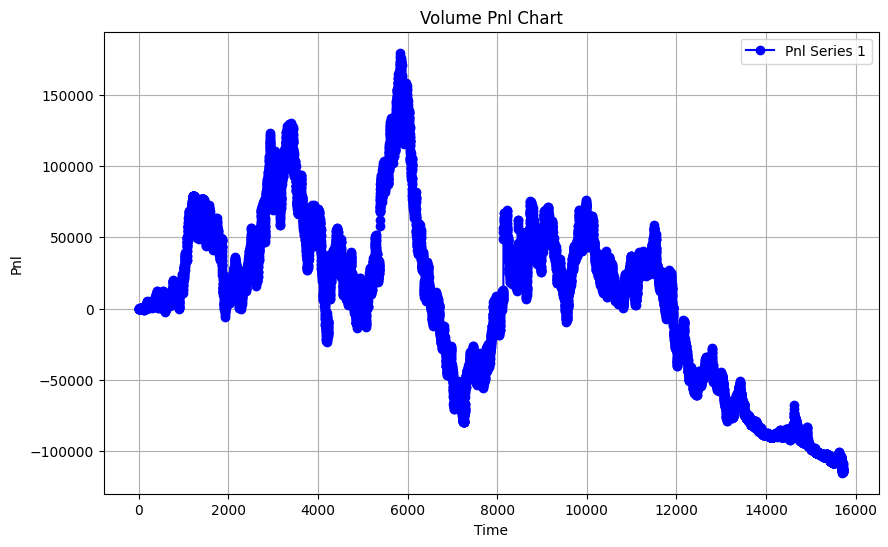

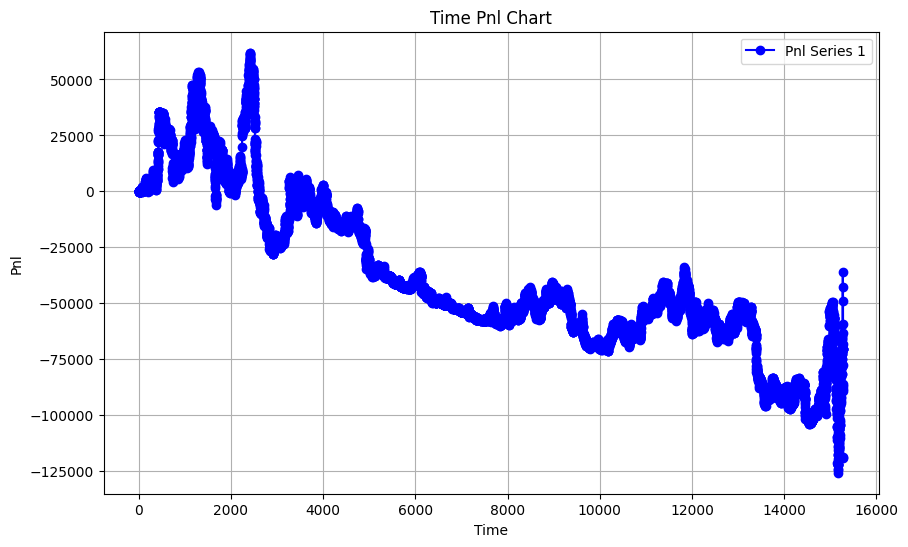

In [22]:
compare_showcase(pnl_volume['total_pnl'],pnl_time['total_pnl'])

海龟策略

In [23]:
def turtle(old_df:pd.DataFrame):
    pnl =[]
    df = deepcopy(old_df)
    df.dropna(inplace= True)
    cost = 0.0002
    df['ATR'] = df['high'] - df['low']
    # position = 0.01 * df['close'].iloc[0] / df['ATR'].iloc[0]
    position = 1 
    cash = -df['close'].iloc[0]*position*(1+cost)
    initial_price = df['close'].iloc[0]
    ATR = df['ATR'].iloc[0]
    for i in range(len(df.index)):
        if df['close'].iloc[i]-initial_price > 0.5*ATR:
            cash -= df['open'].iloc[i+1]*(1+cost)
            position +=1
            ATR = df['ATR'].iloc[i]
            initial_price = df['close'].iloc[i]
        elif initial_price - df['close'].iloc[i] >3*ATR:
            cash +=position*df['open'].iloc[i+1]*(1-cost)
            position =0
            ATR = df['ATR'].iloc[i]
            initial_price = df['close'].iloc[i]
        pnl.append(cash + position*df['close'].iloc[i])
    return pnl

In [24]:
turtle_pnl_volume = turtle(volume)
turtle_pnl_time = turtle(time)

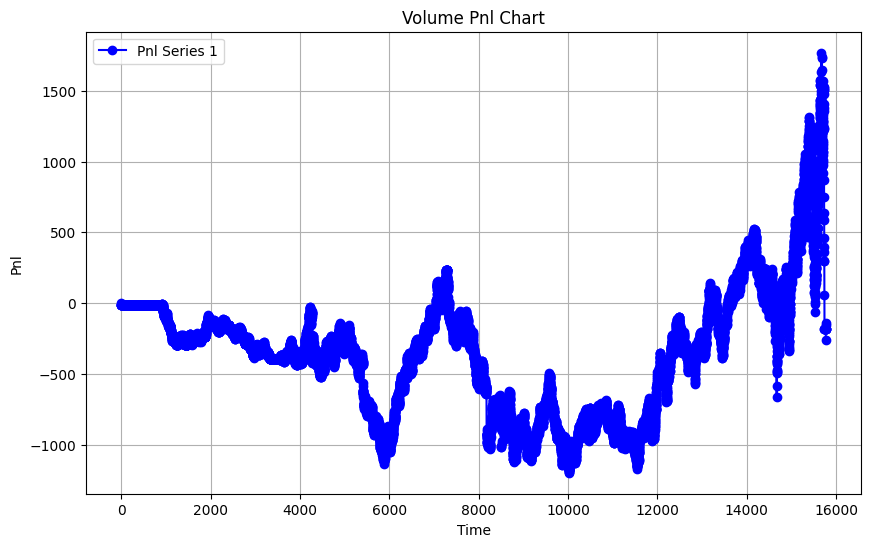

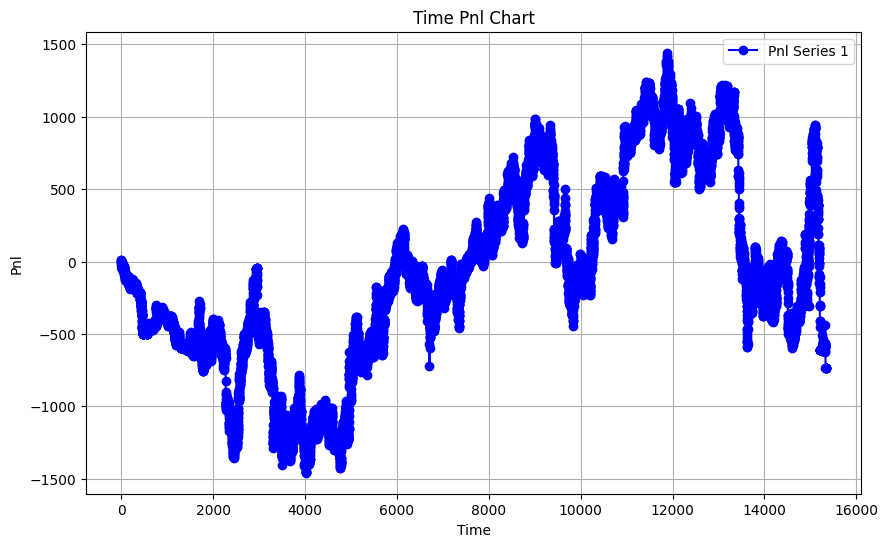

In [25]:
compare_showcase(turtle_pnl_volume,turtle_pnl_time)

逻辑斯蒂回归预测

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt 

def logistic_prediction(df:pd.DataFrame):
    df_copy = deepcopy(df)
    df_copy['diff'] = df_copy['close'].diff()
# 根据差异的正负分配1或-1
    df_copy['result'] = df_copy['diff'].apply(lambda x: 1 if x > 0 else -1)
    data = df_copy['close']
    labels = df_copy['result'] # 标记上升趋势
    X_train,y_train = np.array(df_copy[['high','low','close']][df['t']<'2021-11-22 09:09:49.500000']),np.array(df_copy['result'][df['t']<'2021-11-22 09:09:49.500000'])
    X_test, y_test= np.array(df_copy[['high','low','close']][df['t']>='2021-11-22 09:09:49.500000']),np.array(df_copy['result'][df['t']>='2021-11-22 09:09:49.500000'])
    # 创建逻辑斯蒂回归模型
    model = LogisticRegression()

    # 训练模型
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # 评估模型
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("###################")
    return y_pred

Accuracy: 0.5331680099194048
Classification Report:
               precision    recall  f1-score   support

          -1       0.54      0.84      0.66      1712
           1       0.51      0.18      0.27      1514

    accuracy                           0.53      3226
   macro avg       0.52      0.51      0.46      3226
weighted avg       0.52      0.53      0.48      3226

###################
Accuracy: 0.5687542879545232
Classification Report:
               precision    recall  f1-score   support

          -1       0.58      0.89      0.70      5773
           1       0.51      0.14      0.22      4430

    accuracy                           0.57     10203
   macro avg       0.54      0.52      0.46     10203
weighted avg       0.55      0.57      0.49     10203

###################


C:\Users\pkulu\AppData\Local\Temp\ipykernel_14240\4151700764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logistic_volume['Signal'] = logistic_volume_signal
C:\Users\pkulu\AppData\Local\Temp\ipykernel_14240\4151700764.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logistic_time['Signal'] = logistic_time_signal


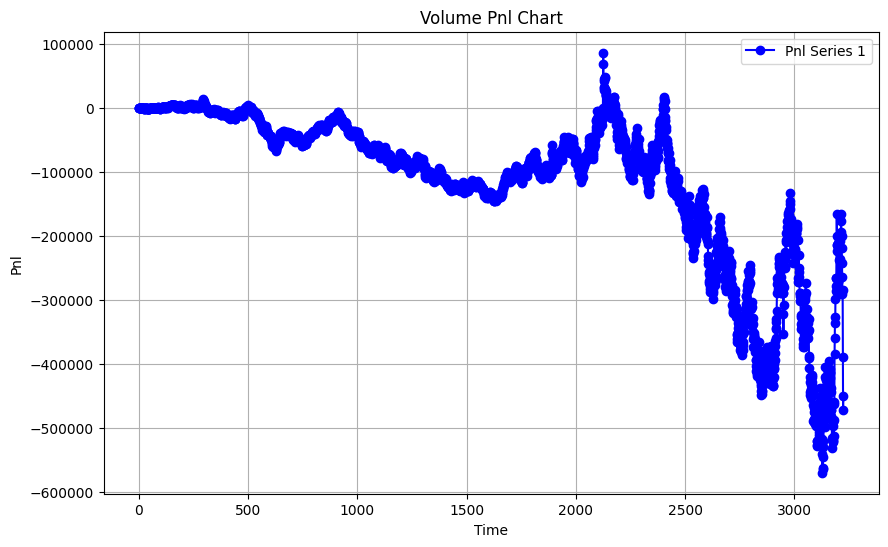

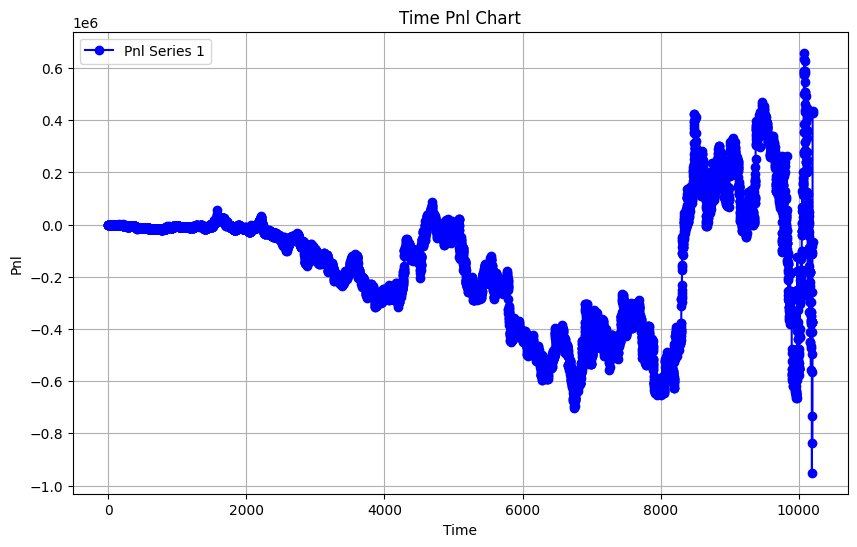

In [27]:
logistic_volume_signal = logistic_prediction(volume)
logistic_time_signal = logistic_prediction(time)
logistic_volume = volume[volume['t']>='2021-11-22 09:09:49.500000']
logistic_time = time[time['t']>='2021-11-22 09:09:49.500000']
logistic_volume['Signal'] = logistic_volume_signal
logistic_time['Signal'] = logistic_time_signal
volume_logistic_pnl = backtest(logistic_volume)
time_logistic_pnl = backtest(logistic_time)
compare_showcase(volume_logistic_pnl['total_pnl'],time_logistic_pnl['total_pnl'])

简单的Transformer预测

见Transformer_model.ipynb